In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Define batch sizes
batch_size_train = 100
batch_size_test = 64

In [3]:
# Data transformation pipeline for normalization
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  
])

In [4]:
# Download and load training data
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=data_transform
)

In [5]:
# Download and load test data
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=data_transform
)

In [6]:
# Create DataLoader for training set
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size_train, shuffle=True
)

In [7]:
# Create DataLoader for test set
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size_test, shuffle=False
)

In [8]:
# defing dnn model, optimizer, and loss function
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)  # LeakyReLU instead of ReLU
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.fc3(x)
        return x
model = DNNModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()

In [9]:
# Function to initialize model and optimizer
def initialize_model_and_optimizer():
    """Initializes the model, optimizer, and loss function."""
    model = DNNModel()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    loss_function = torch.nn.CrossEntropyLoss()
    return model, optimizer, loss_function

In [10]:
# Function to train one epoch
def train_one_epoch(model, train_loader, optimizer, loss_function):
    """Train the model for one epoch and return the average loss."""
    model.train()  # Set model to training mode
    running_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_function(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    return running_loss / len(train_loader)

In [11]:
# Function to log weights and loss
def log_weights_and_loss(model, loss, weights_first_layer, weights_full_model, losses):
    """Logs the weights of the first layer and full model along with the loss."""
    weights_first_layer.append(model.fc1.weight.data.numpy().flatten())
    full_model_weights = np.concatenate([param.data.numpy().flatten() for param in model.parameters()])
    weights_full_model.append(full_model_weights)
    losses.append(loss)

In [12]:
# Main function to train the model over multiple iterations
def train_model(train_loader, epochs=24, tolerance=1e-5):
    """Train the model over multiple iterations and log weights and losses."""
    complete_weights_first_layer, complete_weights_full_model, complete_losses = [], [], []
     # Training loop for 8 iteration
    for t_i in range(8): 
        print(f"Training time: {t_i + 1}")
        # Initialize model, optimizer, and loss function
        model, optimizer, loss_function = initialize_model_and_optimizer()
        weights_first_layer, weights_full_model, losses = [], [], []
        for epoch in range(epochs):
            avg_loss = train_one_epoch(model, train_loader, optimizer, loss_function)
            if epoch % 3 == 0:
                log_weights_and_loss(model, avg_loss, weights_first_layer, weights_full_model, losses)
        # Collect results after each training iteration
        complete_weights_first_layer.append(weights_first_layer)
        complete_weights_full_model.append(weights_full_model)
        complete_losses.append(losses)
    return complete_weights_first_layer, complete_weights_full_model, complete_losses

In [13]:
# Define the data transformation and load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

# Call the train_model function
first_layer_model_weights, full_model_weights, model_losses = train_model(train_loader=trainloader, epochs=24)

Training time: 1
Training time: 2
Training time: 3
Training time: 4
Training time: 5
Training time: 6
Training time: 7
Training time: 8


In [14]:
def perform_pca(weights, n_components=2):
    """Performs PCA on the given weights."""
    weights_flat = np.vstack(weights)
    pca = PCA(n_components=n_components)
    return pca.fit_transform(weights_flat)

In [15]:
def plot_pca_results(pca_data, title, subplot_position):
    """Plots the PCA results in the given subplot position."""
    plt.subplot(subplot_position)
    plt.scatter(pca_data[:, 0], pca_data[:, 1], alpha=0.7)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

In [16]:
# Apply PCA to both full model and first layer weights
weights_full_model_pca = perform_pca(full_model_weights)
weights_first_layer_pca = perform_pca(first_layer_model_weights)

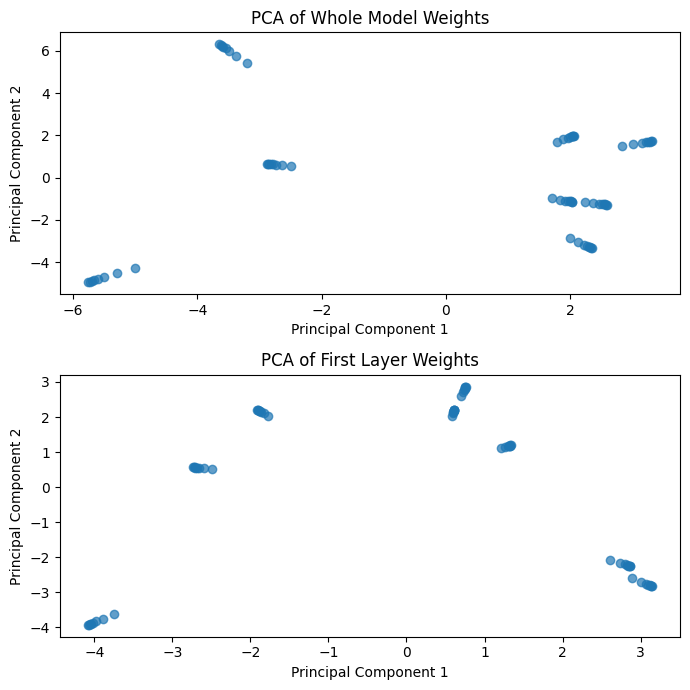

In [19]:
plt.figure(figsize=(7, 7))
plot_pca_results(weights_full_model_pca, 'PCA of Whole Model Weights', 211)
plot_pca_results(weights_first_layer_pca, 'PCA of First Layer Weights', 212)
plt.tight_layout()
plt.show()